# Import Packages

In [134]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH

In [136]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [137]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
   
    global y_pred

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f'R2 Score: {r2_test}, Root Mean Squared Error: {rmse_test}, Mean Absolute Error: {mae_test}')
    
    y_pred = y_pred_test
   
    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test



In [138]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse_train':[],
                             'score_rmse_test':[],
                             'score_mae_train':[],
                             'score_mae_test':[],
                             'score_r2_train':[],
                             'score_r2_test':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [139]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse_train, score_rmse_test, score_mae_train, score_mae_test, score_r2_train, score_r2_test, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row_df = pd.DataFrame([{
        'model_type': model_type,
        'train_test_split': train_test_split,
        'is_pca': is_pca,
        'score_rmse_train': score_rmse_train,
        'score_rmse_test': score_rmse_test,
        'score_mae_train': score_mae_train,
        'score_mae_test': score_mae_test,
        'score_r2_train': score_r2_train,
        'score_r2_test': score_r2_test,
        'cv_mean_r2': cv_mean_r2,
        'cv_std_r2': cv_std_r2,
        'cv_mean_rmse': cv_mean_rmse,
        'cv_std_rmse': cv_std_rmse,
        'cv_mean_mae': cv_mean_mae,
        'cv_std_mae': cv_std_mae,
        'best_params': best_params
    }])

    model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)

In [140]:
# import train/test splits for modeling the reduced and robust scaled data
X_train_rr = pd.read_csv(DATA_PATH + 'modeling/X_train_reduced_robust.csv')
X_test_rr = pd.read_csv(DATA_PATH + 'modeling/X_test_reduced_robust.csv')

# import train/test splits for modeling the reduced and power transformed data
X_train_rp = pd.read_csv(DATA_PATH + 'modeling/X_train_reduced_power.csv')
X_test_rp = pd.read_csv(DATA_PATH + 'modeling/X_test_reduced_power.csv')

# import train/test splits for modeling the imputed and robust scaled data
X_train_ir = pd.read_csv(DATA_PATH + 'modeling/X_train_imputed_robust.csv')
X_test_ir = pd.read_csv(DATA_PATH + 'modeling/X_test_imputed_robust.csv')

# import train/test splits for modeling the imputed and power transformed data
X_train_ip = pd.read_csv(DATA_PATH + 'modeling/X_train_imputed_power.csv')
X_test_ip = pd.read_csv(DATA_PATH + 'modeling/X_test_imputed_power.csv')

y_train = pd.read_csv(DATA_PATH + 'modeling/y_train_data.csv').values.ravel()
y_test = pd.read_csv(DATA_PATH + 'modeling/y_test_data.csv').values.ravel()

y_train_rounded = pd.read_csv(DATA_PATH + 'modeling/y_train_rounded.csv').values.ravel()
y_test_rounded = pd.read_csv(DATA_PATH + 'modeling/y_test_rounded.csv').values.ravel()

# Linear Models

## I. Reduced & Robust Scaled Data


In [141]:
print(X_train_rr.shape, y_train.shape, y_train_rounded.shape)
print(X_test_rr.shape, y_test.shape, y_test_rounded.shape)

(938, 54) (938,) (938,)
(402, 54) (402,) (402,)


### A. Linear Regression

In [142]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (-0.099065839141839, 1.434593545097477),
 'neg_mean_squared_error': (-6890003883517.846, 8430001607889.046),
 'neg_mean_absolute_error': (-1165344.3313636119, 134367.94104657855)}

#### Model Training and Evaluation

R2 Score: 0.6354819282483085, Root Mean Squared Error: 1820422.08292154, Mean Absolute Error: 1163944.8036537073


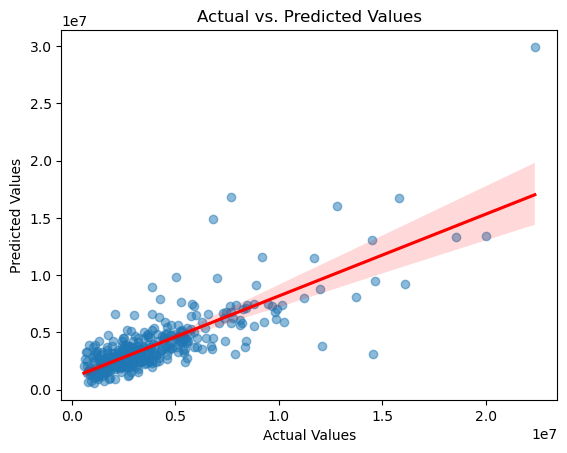

In [143]:
linear_model.fit(X_train_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [144]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,0.0,1.428130e+06,1.820422e+06,1.015148e+06,1.163945e+06,0.701376,0.635482,-0.099066,1.434594,-6.890004e+12,8.430002e+12,-1.165344e+06,134367.941047,None


### B. Linear Regression with PCA

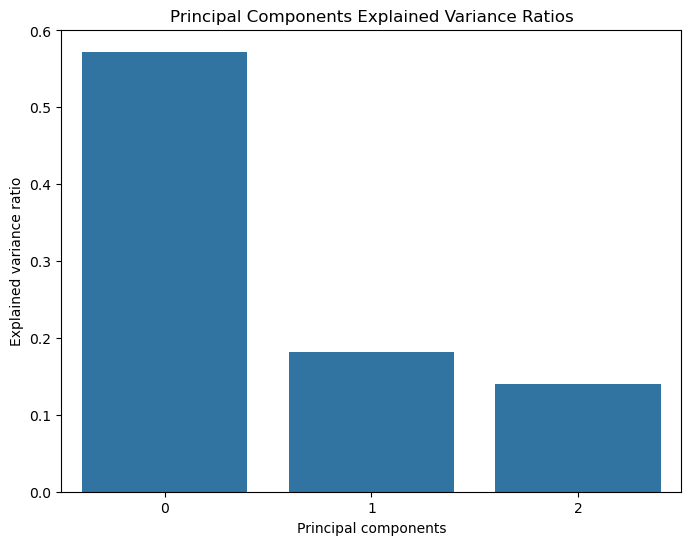

                             PC 1      PC 2      PC 3
public_insurance         0.963467 -0.006958 -0.015754
public_insurance_ratio   0.264398 -0.016582 -0.053439
migrant_patients         0.028162  0.005255  0.976329
public_housing_patients  0.013665  0.006740  0.007931
lep_patients             0.011407  0.026765  0.026411
hispanic_any_race        0.009981  0.035492  0.036728
total_other_revenue      0.009262  0.997710 -0.009706
homeless_patients        0.008345  0.013176  0.014612
medicaid                 0.007891  0.022512  0.019076
total_patients           0.007625  0.016745  0.017129
diverse_patients_sum     0.007304  0.003937  0.001715
school_based_patients    0.006937  0.004127  0.014577
low_income               0.006373  0.018828  0.018196
uninsured                0.006318  0.007538  0.015856
total_grant_funding      0.005569  0.016042  0.005851


In [145]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_rr)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rr)
X_test_pca = pca.transform(X_test_rr)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_rr.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [146]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_rr.index)
X_train_pca_rr = pd.concat([X_train_rr, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_rr.index)
X_test_pca_rr = pd.concat([X_test_rr, X_test_pca_df], axis=1)

R2 Score: 0.6339783054809596, Root Mean Squared Error: 1824172.8038997096, Mean Absolute Error: 1170075.3084577115


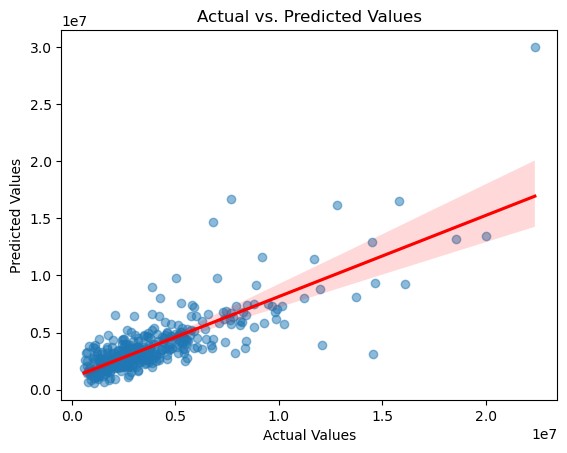

In [147]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6355182297537149, Root Mean Squared Error: 1821045.5594671834, Mean Absolute Error: 1164526.0086569295


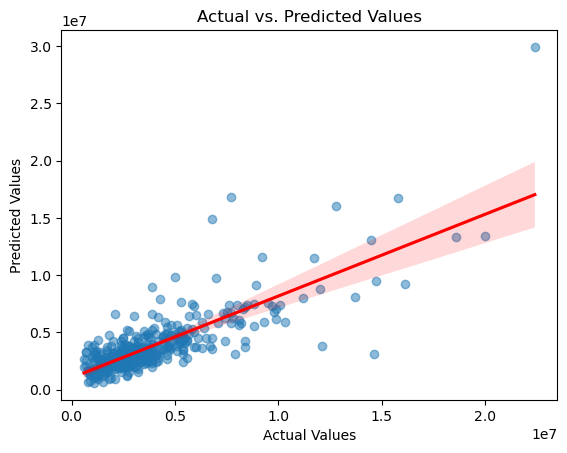

In [148]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_rr, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## II. Reduced & Power Transformed Data

### A. Linear Regression

In [149]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6116716249856359, 0.029933941453361056),
 'neg_mean_squared_error': (-2614447687930.0923, 466914009494.30414),
 'neg_mean_absolute_error': (-1157588.3636340175, 83284.99796756227)}

R2 Score: 0.6118016478017408, Root Mean Squared Error: 1878622.0124820126, Mean Absolute Error: 1298752.850585242


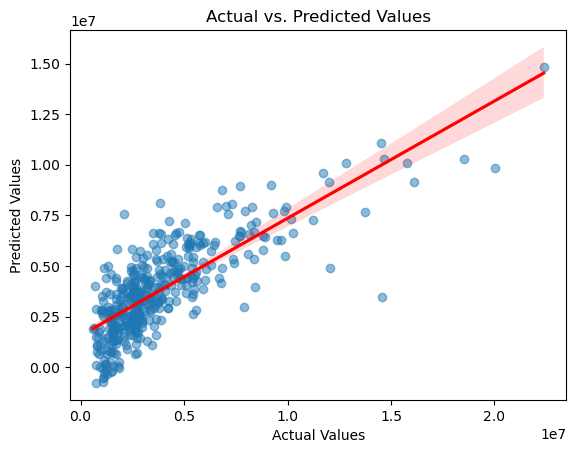

In [150]:
linear_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### B. Linear Regression with PCA

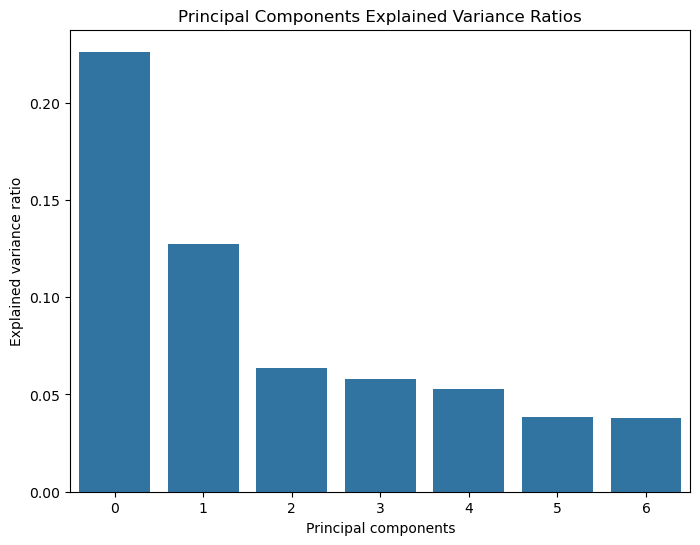

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.262935  0.111790 -0.001578 -0.032880 -0.041722   
low_income                   0.256204 -0.006107  0.042423 -0.008781 -0.131664   
medicaid                     0.255660  0.066268  0.011913 -0.129381 -0.029966   
hispanic_any_race            0.247482 -0.071140 -0.123799  0.109777  0.033578   
lep_patients                 0.239514 -0.099791 -0.125464  0.073685  0.072974   
uninsured                    0.234638 -0.029093 -0.046645  0.119001 -0.037627   
total_grant_funding          0.232390  0.018409  0.022473  0.012346  0.020338   
TotalWeeklyHoursOfOperation  0.213827  0.126096  0.091991  0.003644 -0.158271   
ZipCode_Count                0.205785  0.041705  0.050012 -0.081887 -0.033706   
total_sites                  0.201562  0.121286  0.106915  0.006267 -0.178980   
diverse_patients_sum         0.192964 -0.042200  0.135499 -0.221765 -0.011688   
medicare_18_up              

In [151]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_rp)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rp)
X_test_pca = pca.transform(X_test_rp)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_rp.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [152]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_rp.index)
X_train_pca_rp = pd.concat([X_train_rp, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_rp.index)

X_test_pca_rp = pd.concat([X_test_rp, X_test_pca_df], axis=1)

R2 Score: 0.6139153858761905, Root Mean Squared Error: 1873500.4875938813, Mean Absolute Error: 1295228.1238782045


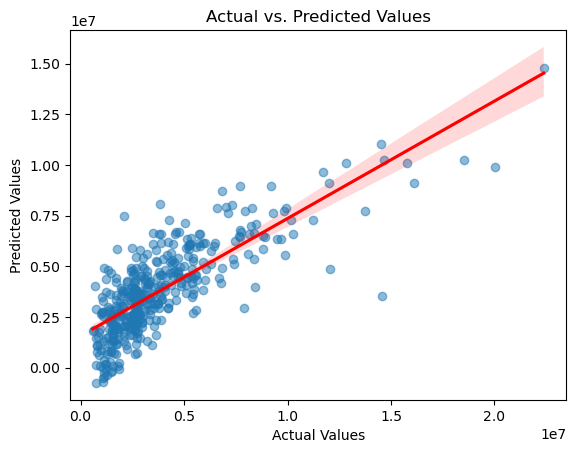

In [153]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rp, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

In [154]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores



{'r2': (0.611451944781994, 0.02937860842950848),
 'neg_mean_squared_error': (-2615386098020.303, 474224873802.53723),
 'neg_mean_absolute_error': (-1158858.3377373044, 84820.07983533284)}

R2 Score: 0.6118513267197944, Root Mean Squared Error: 1879238.7472720712, Mean Absolute Error: 1301640.2148418382


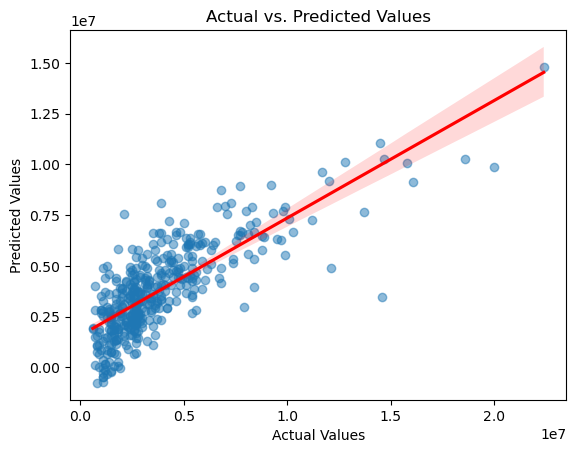

In [155]:
linear_model.fit(X_train_rp, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## III. Imputed & Robust Scaled Data

### A. Linear Regression

In [156]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.2996435221230047, 0.6486173569026071),
 'neg_mean_squared_error': (-4506200514071.935, 3765423828388.6836),
 'neg_mean_absolute_error': (-1136366.7239532983, 112682.88370452436)}

R2 Score: 0.6141074408149965, Root Mean Squared Error: 1873034.4501421193, Mean Absolute Error: 1190298.7392833645


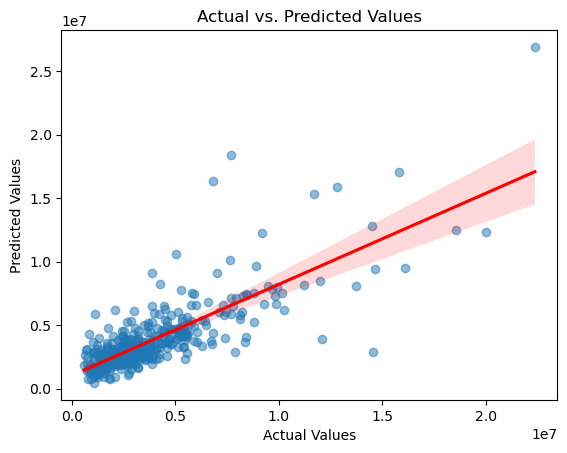

In [157]:
linear_model.fit(X_train_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

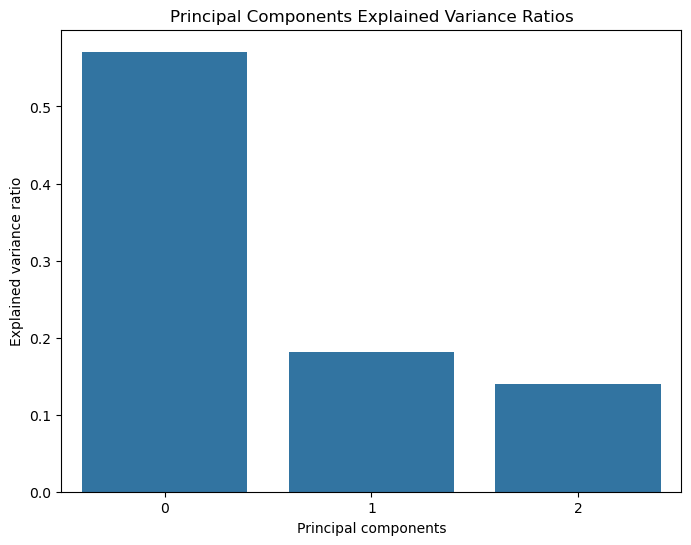

                             PC 1      PC 2      PC 3
public_insurance         0.963338 -0.007597 -0.016263
public_insurance_ratio   0.264318 -0.017112 -0.053900
migrant_patients         0.028311  0.007750  0.975811
public_housing_patients  0.013693  0.006893  0.008111
lep_patients             0.011433  0.026917  0.026441
hispanic_any_race        0.010011  0.035666  0.036729
total_other_revenue      0.009467  0.997118 -0.013104
total_sfs                0.008854  0.029092  0.012553
homeless_patients        0.008370  0.013314  0.014717
medicaid                 0.007913  0.022628  0.019109
total_patients           0.007647  0.016861  0.017182
total_visits             0.007575  0.009108  0.014450
diverse_patients_sum     0.007317  0.004001  0.001790
total_cost_care          0.007219  0.007727  0.012681
school_based_patients    0.006971  0.004335  0.014803


In [158]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_ir)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ir)
X_test_pca = pca.transform(X_test_ir)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_ir.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [159]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_ir.index)
X_train_pca_ir = pd.concat([X_train_ir, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_ir.index)
X_test_pca_ir = pd.concat([X_test_ir, X_test_pca_df], axis=1)


R2 Score: 0.6152660993228606, Root Mean Squared Error: 1870220.404193063, Mean Absolute Error: 1191916.2537313432


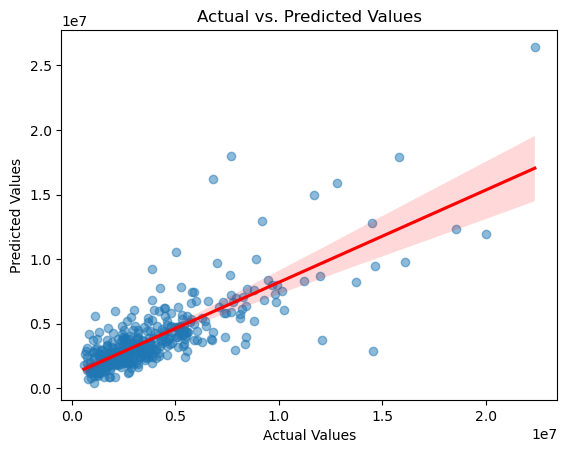

In [160]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ir, X_test_pca_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6139497798634854, Root Mean Squared Error: 1874151.9865454817, Mean Absolute Error: 1191498.7115013457


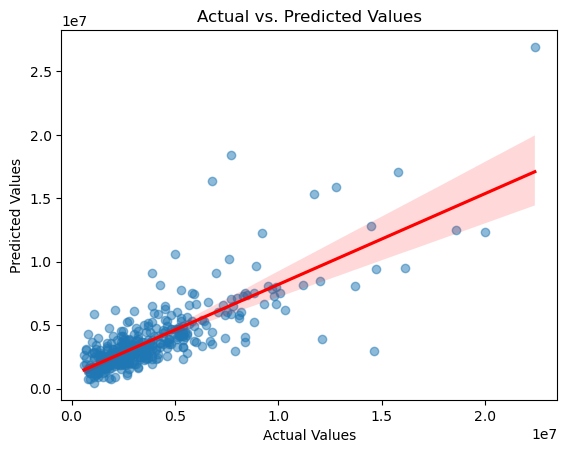

In [161]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ir, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## IV. Imputed & Power Transformed Data

### A. Linear Regression

In [162]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.609942103305639, 0.03422828824474123),
 'neg_mean_squared_error': (-2619495181309.575, 440701053620.8061),
 'neg_mean_absolute_error': (-1154347.8670429871, 84858.58974753803)}

R2 Score: 0.6158055501969626, Root Mean Squared Error: 1868908.788645013, Mean Absolute Error: 1287723.5778286383


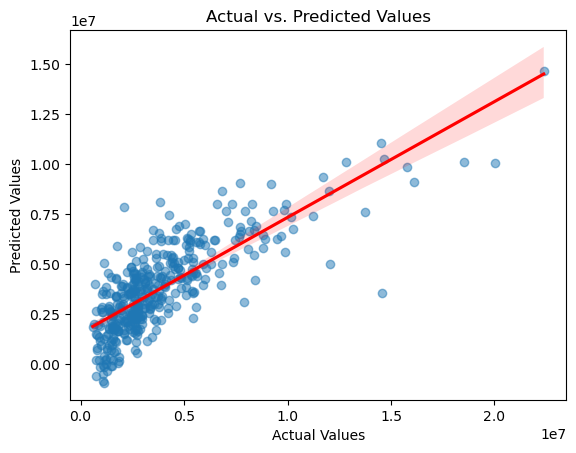

In [163]:
linear_model.fit(X_train_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

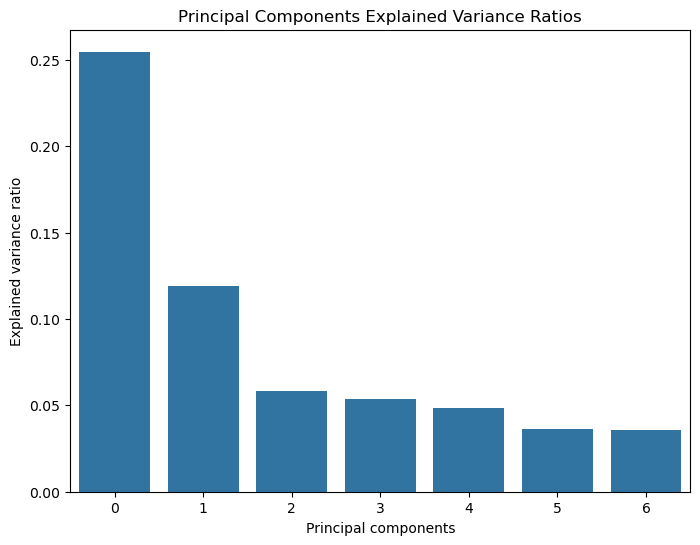

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.241294  0.097965 -0.007399 -0.036233 -0.036238   
total_visits                 0.241125  0.089438  0.018492 -0.028657 -0.030978   
total_cost_care              0.237108  0.080908  0.037157 -0.020607  0.009984   
medicaid                     0.231784  0.054972  0.009221 -0.139147 -0.026115   
low_income                   0.231029 -0.019205  0.036906 -0.011365 -0.119469   
hispanic_any_race            0.220803 -0.084127 -0.131157  0.097530  0.038880   
total_grant_funding          0.213363  0.006272  0.020496  0.009606  0.020430   
uninsured                    0.212121 -0.044109 -0.057483  0.121900 -0.027787   
lep_patients                 0.211905 -0.111711 -0.133405  0.060131  0.077202   
total_sfs                    0.196326 -0.046486 -0.046442  0.096819  0.014079   
TotalWeeklyHoursOfOperation  0.194581  0.113036  0.086439  0.003865 -0.143424   
ZipCode_Count               

In [164]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_ip)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ip)
X_test_pca = pca.transform(X_test_ip)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_ip.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [165]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_ip.index)
X_train_pca_ip = pd.concat([X_train_ip, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_ip.index)

X_test_pca_ip = pd.concat([X_test_ip, X_test_pca_df], axis=1)



R2 Score: 0.6170883020489355, Root Mean Squared Error: 1865786.215389677, Mean Absolute Error: 1285356.5524639115


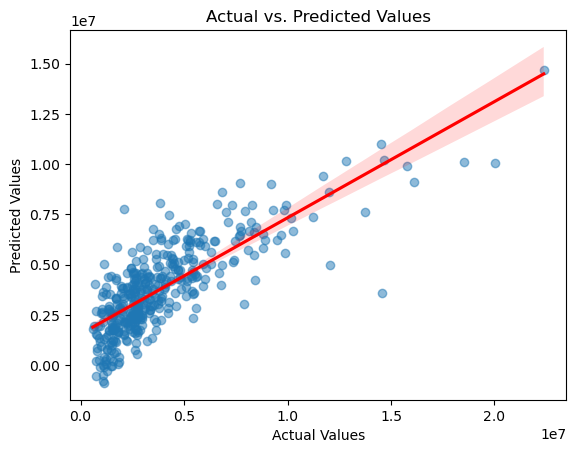

In [166]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ip, X_test_pca_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [167]:
add_model_score('Linear Regression', 'imputed_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6159700963746602, Root Mean Squared Error: 1869241.554138395, Mean Absolute Error: 1289469.604099425


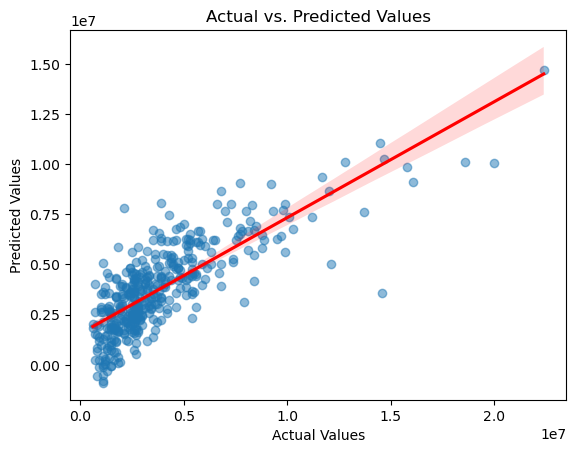

In [168]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ip, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

# Scores Analysis

In [193]:
model_scores.sort_values('cv_mean_r2',ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
3,Linear Regression,reduced_power,False,1.505265e+06,1.878622e+06,1.082376e+06,1.298753e+06,0.668247,0.611802,0.611672,0.029934,-2.614448e+12,4.669140e+11,-1.157588e+06,83284.997968,None
4,Linear Regression,reduced_power,True,1.505951e+06,1.873500e+06,1.082952e+06,1.295228e+06,0.667945,0.613915,0.611672,0.029934,-2.614448e+12,4.669140e+11,-1.157588e+06,83284.997968,None
5,Linear Regression,reduced_power_rounded,False,1.505423e+06,1.879239e+06,1.083451e+06,1.301640e+06,0.668066,0.611851,0.611452,0.029379,-2.615386e+12,4.742249e+11,-1.158858e+06,84820.079835,None
9,Linear Regression,imputed_power,False,1.496592e+06,1.868909e+06,1.074059e+06,1.287724e+06,0.672059,0.615806,0.609942,0.034228,-2.619495e+12,4.407011e+11,-1.154348e+06,84858.589748,None
10,Linear Regression,imputed_power,True,1.497492e+06,1.865786e+06,1.073445e+06,1.285357e+06,0.671665,0.617088,0.609942,0.034228,-2.619495e+12,4.407011e+11,-1.154348e+06,84858.589748,None
11,Linear Regression,imputed_power_rounded,False,1.496795e+06,1.869242e+06,1.075354e+06,1.289470e+06,0.671860,0.615970,0.609679,0.033456,-2.620830e+12,4.482436e+11,-1.156030e+06,85928.797901,None
8,Linear Regression,imputed_robust_rounded,False,1.406474e+06,1.874152e+06,9.979640e+05,1.191499e+06,0.710267,0.613950,0.300213,0.647211,-4.495665e+12,3.743501e+12,-1.136279e+06,113587.858048,None
6,Linear Regression,imputed_robust,False,1.406830e+06,1.873034e+06,9.982975e+05,1.190299e+06,0.710218,0.614107,0.299644,0.648617,-4.506201e+12,3.765424e+12,-1.136367e+06,112682.883705,None
7,Linear Regression,imputed_robust,True,1.443157e+06,1.870220e+06,1.011811e+06,1.191916e+06,0.695059,0.615266,0.299644,0.648617,-4.506201e+12,3.765424e+12,-1.136367e+06,112682.883705,None
2,Linear Regression,reduced_robust_rounded,False,1.427679e+06,1.821046e+06,1.014567e+06,1.164526e+06,0.701465,0.635518,-0.098124,1.432765,-6.869986e+12,8.391041e+12,-1.164869e+06,134165.105598,None


# Ensemble Models

## I. Reduced & Robust Scaled Data

##### Importing Data

### C. Random Forest Regression

In [170]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rr, y_train)

y_pred = rf_gridsearch.predict(X_test_rr)
print(rf_gridsearch.score(X_test_rr, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6514058105493652
Best parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6545504567883009, Root Mean Squared Error: 1772167.9353218225, Mean Absolute Error: 1137364.2841542289


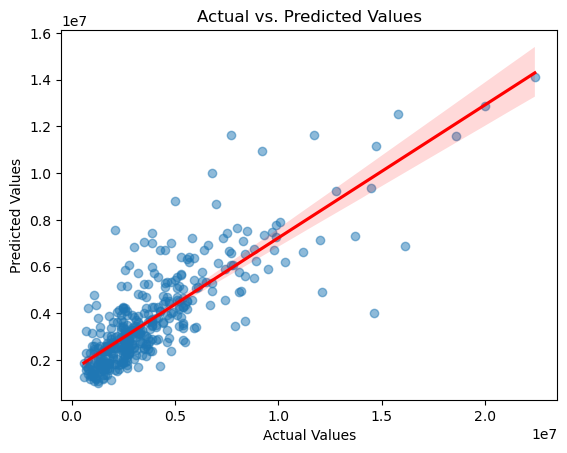

                             feature_importance
total_patients                         0.117851
uninsured                              0.112419
TotalWeeklyHoursOfOperation            0.087439
hispanic_any_race                      0.073398
low_income                             0.062093
total_grant_funding                    0.053346
total_sites                            0.048886
medicaid                               0.043824
lep_patients                           0.031368
diverse_patients_sum                   0.027559
medicare_18_up                         0.023246
ZipCode_Count                          0.022405
SiteCity_Count                         0.020420
homeless_patients                      0.019706
migrant_patients                       0.019298


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [171]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6545372718382164, Root Mean Squared Error: 1772201.7546208734, Mean Absolute Error: 1147560.7883333333


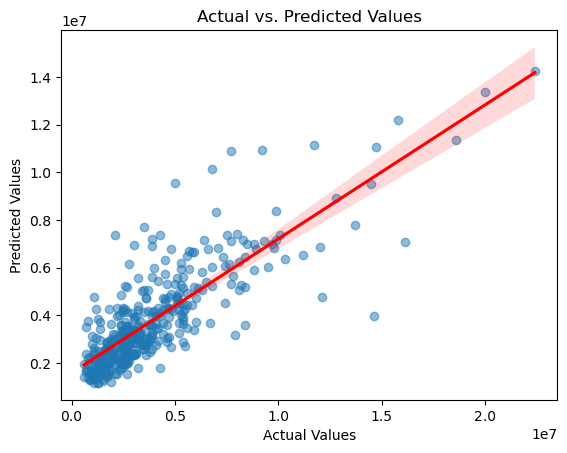

                             feature_importance
uninsured                              0.141000
TotalWeeklyHoursOfOperation            0.111203
total_patients                         0.085534
total_sites                            0.057487
total_grant_funding                    0.054181
hispanic_any_race                      0.053990
low_income                             0.052141
medicaid                               0.041205
diverse_patients_sum                   0.028673
lep_patients                           0.023162
private_insurance                      0.022285
medicare_18_up                         0.021868
PC 1                                   0.018325
homeless_patients                      0.016254
SiteCity_Count                         0.015489


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [172]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6584958266802542, Root Mean Squared Error: 1762710.1815328582, Mean Absolute Error: 1139666.6666666667


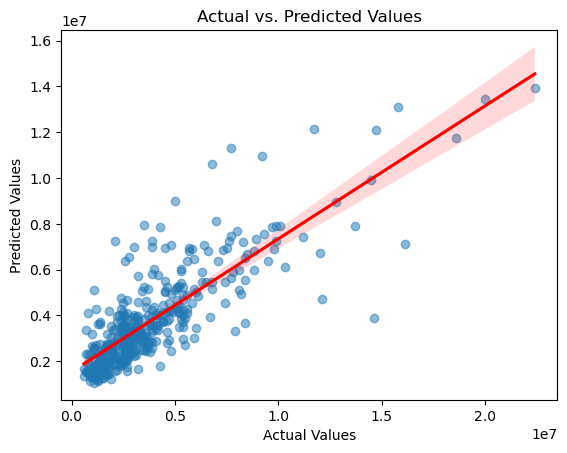

                             feature_importance
uninsured                              0.123617
total_patients                         0.112112
TotalWeeklyHoursOfOperation            0.099661
low_income                             0.074098
medicaid                               0.057934
total_grant_funding                    0.056371
hispanic_any_race                      0.056286
total_sites                            0.039360
lep_patients                           0.031430
diverse_patients_sum                   0.021154
ZipCode_Count                          0.018818
SiteCity_Count                         0.018720
homeless_patients                      0.017425
private_insurance                      0.016424
uninsured_ratio                        0.016355


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [173]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## II. Reduced & Power Transformed Data

##### Importing Data

### C. Random Forest Regressor with GridSearch

In [174]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rp, y_train)

y_pred = rf_gridsearch.predict(X_test_rp)
print(rf_gridsearch.score(X_test_rp, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6531752755717671
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.6499539151611695, Root Mean Squared Error: 1783919.181698568, Mean Absolute Error: 1152872.8804778892


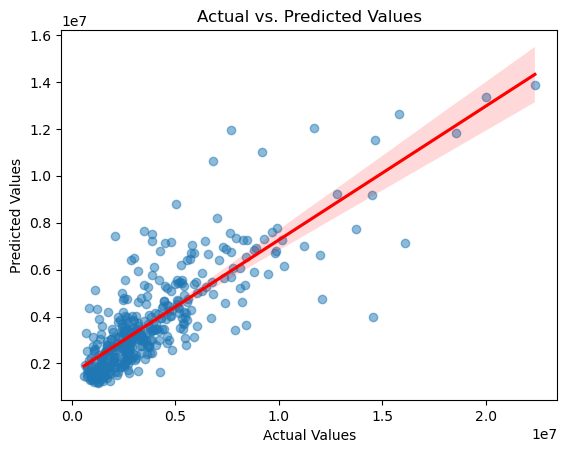

                             feature_importance
uninsured                              0.131349
total_patients                         0.118558
TotalWeeklyHoursOfOperation            0.080857
hispanic_any_race                      0.066606
low_income                             0.063866
medicaid                               0.058868
total_grant_funding                    0.049091
total_sites                            0.047673
diverse_patients_sum                   0.032908
lep_patients                           0.030201
medicare_18_up                         0.020032
homeless_patients                      0.018990
private_insurance                      0.018926
SiteCity_Count                         0.018371
ZipCode_Count                          0.016867


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [175]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6504852507026, Root Mean Squared Error: 1782564.760569414, Mean Absolute Error: 1149493.23897366


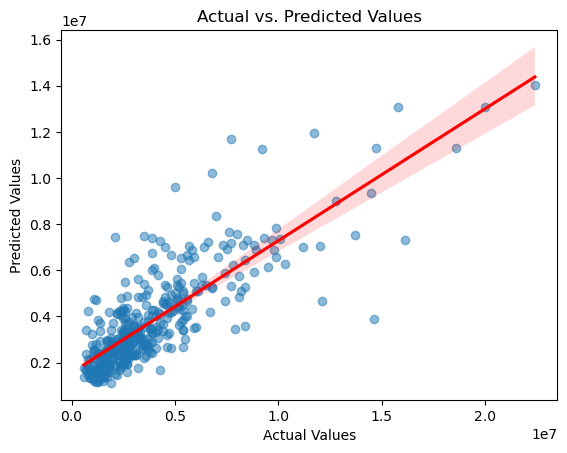

                             feature_importance
uninsured                              0.126938
PC 1                                   0.119453
TotalWeeklyHoursOfOperation            0.092161
total_patients                         0.084259
low_income                             0.052932
hispanic_any_race                      0.051447
total_grant_funding                    0.042835
total_sites                            0.036357
medicaid                               0.034382
lep_patients                           0.028725
diverse_patients_sum                   0.019935
SiteCity_Count                         0.017160
medicare_18_up                         0.016992
homeless_patients                      0.015600
PC 4                                   0.012440


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [176]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6570924510898591, Root Mean Squared Error: 1766328.3045967238, Mean Absolute Error: 1144377.1126067592


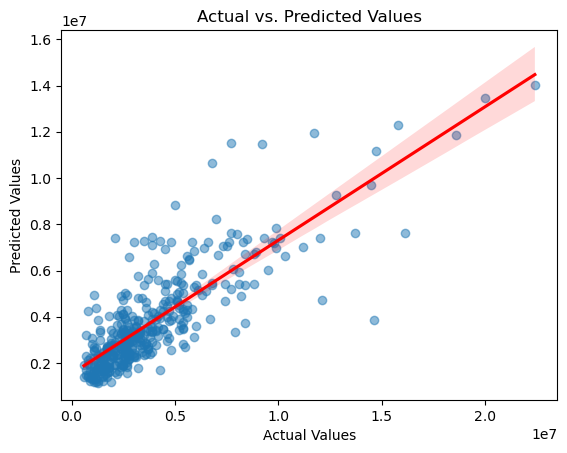

                             feature_importance
uninsured                              0.136316
total_patients                         0.108009
TotalWeeklyHoursOfOperation            0.094902
low_income                             0.073557
total_grant_funding                    0.055031
hispanic_any_race                      0.054749
medicaid                               0.050988
total_sites                            0.049525
lep_patients                           0.035507
diverse_patients_sum                   0.027069
medicare_18_up                         0.018514
homeless_patients                      0.017826
private_insurance                      0.017678
migrant_patients                       0.017656
SiteCity_Count                         0.017623


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [177]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power_rounded', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## III. Imputed & Robust Scaled Data

##### Importing Data

### B. Random Forest Regressor

In [178]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_ir, y_train)

y_pred = rf_gridsearch.predict(X_test_ir)
print(rf_gridsearch.score(X_test_ir, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6480183534455672
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.6409799364461259, Root Mean Squared Error: 1806641.2530969696, Mean Absolute Error: 1187744.2037208115


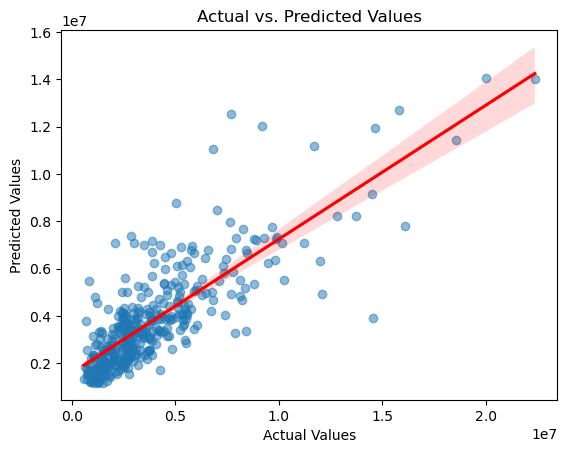

                             feature_importance
uninsured                              0.128078
total_patients                         0.115114
total_sfs                              0.076949
TotalWeeklyHoursOfOperation            0.057472
total_visits                           0.050705
hispanic_any_race                      0.042496
low_income                             0.041711
total_cost_care                        0.039414
total_grant_funding                    0.038119
lep_patients                           0.034969
diverse_patients_sum                   0.030712
total_sites                            0.027365
medicaid                               0.025292
SiteCity_Count                         0.020255
enabling_patients                      0.014793


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [179]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6265759490083065, Root Mean Squared Error: 1843249.1757165673, Mean Absolute Error: 1205092.033146236


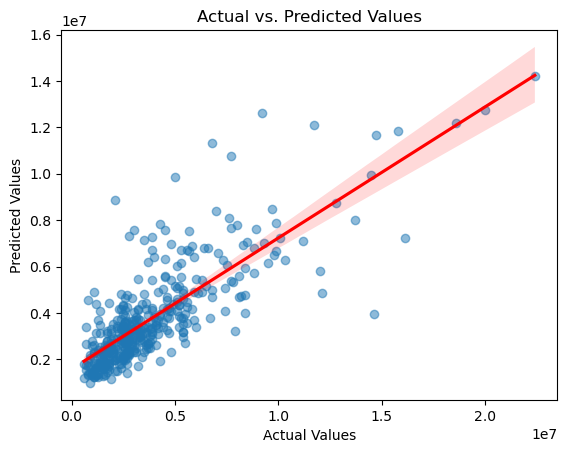

                             feature_importance
total_patients                         0.138685
uninsured                              0.086632
total_cost_care                        0.077712
TotalWeeklyHoursOfOperation            0.072964
total_sfs                              0.063076
total_visits                           0.061393
low_income                             0.044046
medicaid                               0.041890
total_grant_funding                    0.033222
hispanic_any_race                      0.032364
lep_patients                           0.031979
total_sites                            0.028662
diverse_patients_sum                   0.018570
uninsured_ratio                        0.017000
homeless_patients                      0.012751


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [180]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## IV. Imputed & Power Transformed Data

##### Importing Data

### B. Random Forest Regressor

In [181]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, scoring='r2', cv=kf)

rf_gridsearch.fit(X_train_ip, y_train)

y_pred = rf_gridsearch.predict(X_test_ip)
print(rf_gridsearch.score(X_test_ip, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6494917192301446
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 20, 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.47398027616319327, Root Mean Squared Error: 2186822.720695125, Mean Absolute Error: 1312048.0797014926


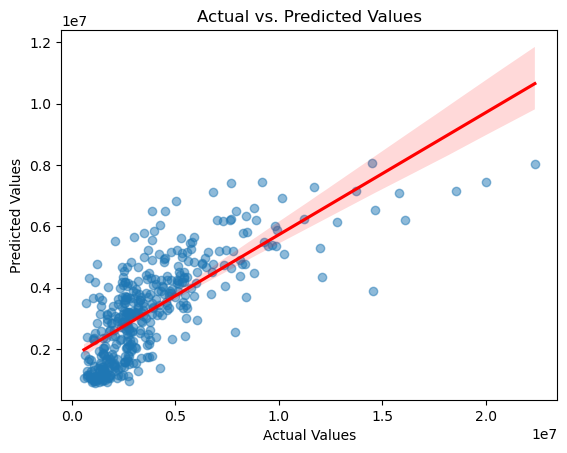

                             feature_importance
uninsured                              0.169636
total_patients                         0.121521
TotalWeeklyHoursOfOperation            0.085894
total_visits                           0.073276
total_sfs                              0.063903
total_cost_care                        0.055409
hispanic_any_race                      0.050693
total_grant_funding                    0.026376
low_income                             0.025606
total_sites                            0.023617
medicaid                               0.020257
diverse_patients_sum                   0.013348
lep_patients                           0.012417
SiteCity_Count                         0.012092
medicare_18_up                         0.011000


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [182]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.4660684892024568, Root Mean Squared Error: 2204071.513007855, Mean Absolute Error: 1305028.6069651742


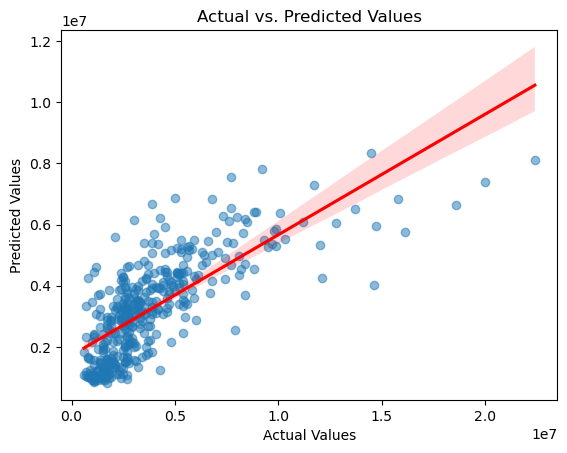

                             feature_importance
uninsured                              0.168291
total_patients                         0.114973
TotalWeeklyHoursOfOperation            0.082349
total_visits                           0.075452
total_sfs                              0.066040
total_cost_care                        0.056978
hispanic_any_race                      0.043050
low_income                             0.037008
total_grant_funding                    0.030915
total_sites                            0.021538
medicaid                               0.016939
SiteCity_Count                         0.014296
lep_patients                           0.013205
diverse_patients_sum                   0.013091
homeless_patients                      0.011193


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_33625/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [183]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

# Scoring Summary

In [184]:
model_scores.sort_values('score_r2_test', ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
14,Random Forest Regressor,reduced_robust_rounded,False,5.847739e+05,1.762710e+06,3.946812e+05,1.139667e+06,0.949915,0.658496,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
17,Random Forest Regressor,reduced_power_rounded,True,6.982635e+05,1.766328e+06,5.215925e+05,1.144377e+06,0.928588,0.657092,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
12,Random Forest Regressor,reduced_robust,False,5.859387e+05,1.772168e+06,4.003667e+05,1.137364e+06,0.949732,0.654550,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
13,Random Forest Regressor,reduced_robust,True,6.073739e+05,1.772202e+06,3.997329e+05,1.147561e+06,0.945987,0.654537,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
16,Random Forest Regressor,reduced_power,True,6.915158e+05,1.782565e+06,5.127352e+05,1.149493e+06,0.929985,0.650485,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
15,Random Forest Regressor,reduced_power,False,7.072940e+05,1.783919e+06,5.273112e+05,1.152873e+06,0.926753,0.649954,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
18,Random Forest Regressor,imputed_robust,False,7.303198e+05,1.806641e+06,5.399342e+05,1.187744e+06,0.921907,0.640980,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,reduced_robust_rounded,False,1.427679e+06,1.821046e+06,1.014567e+06,1.164526e+06,0.701465,0.635518,-0.098124,1.432765,-6.869986e+12,8.391041e+12,-1.164869e+06,134165.105598,None
0,Linear Regression,reduced_robust,0.0,1.428130e+06,1.820422e+06,1.015148e+06,1.163945e+06,0.701376,0.635482,-0.099066,1.434594,-6.890004e+12,8.430002e+12,-1.165344e+06,134367.941047,None
1,Linear Regression,reduced_robust,True,1.457498e+06,1.824173e+06,1.026792e+06,1.170075e+06,0.688969,0.633978,-0.099066,1.434594,-6.890004e+12,8.430002e+12,-1.165344e+06,134367.941047,None


In [185]:
best_forest = model_scores[model_scores['model_type'] == 'Random Forest Regressor']\
                .sort_values('score_r2_test', ascending=False).head(2)
best_linreg = model_scores[model_scores['model_type'] == 'Linear Regression']\
                .sort_values('score_r2_test', ascending=False).head(2)

top_models = pd.concat([best_forest, best_linreg], ignore_index=True)
top_models

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Random Forest Regressor,reduced_robust_rounded,False,5.847739e+05,1.762710e+06,3.946812e+05,1.139667e+06,0.949915,0.658496,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Random Forest Regressor,reduced_power_rounded,True,6.982635e+05,1.766328e+06,5.215925e+05,1.144377e+06,0.928588,0.657092,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,reduced_robust_rounded,False,1.427679e+06,1.821046e+06,1.014567e+06,1.164526e+06,0.701465,0.635518,-0.098124,1.432765,-6.869986e+12,8.391041e+12,-1.164869e+06,134165.105598,None
3,Linear Regression,reduced_robust,0.0,1.428130e+06,1.820422e+06,1.015148e+06,1.163945e+06,0.701376,0.635482,-0.099066,1.434594,-6.890004e+12,8.430002e+12,-1.165344e+06,134367.941047,None


In [186]:
print(list(top_models[top_models['model_type'] == 'Random Forest Regressor']['best_params'].head(1)))

[{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}]


# Model Tuning

**Imputed Robust Rounded RF Model**

Best parameters: [{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}]


In [187]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [80, 100, 120],  # Explore around the best found
    'max_depth': [None, 50, 100],    # Explore deeper trees and unrestricted
    'max_features': ['sqrt', 0.5, 'log2'],  # Include a fractional option
    'min_samples_split': [2, 4, 6],  # A bit more granularity around the best found
    'min_samples_leaf': [1, 2, 4],   # Investigate slightly larger leaves
    'criterion': ['friedman_mse', 'squared_error'],  # Include standard MSE for comparison
    'bootstrap': [True],             # Keep as is if no need to change
    'n_jobs': [-1],                  # Use all processors for speed
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_ir, y_train)

y_pred = forest_gs.predict(X_test_ir)
print(forest_gs.score(X_test_ir, y_test))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6560609131094791
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6421669318062164, Root Mean Squared Error: 1803652.2136819996, Mean Absolute Error: 1170875.5912828902


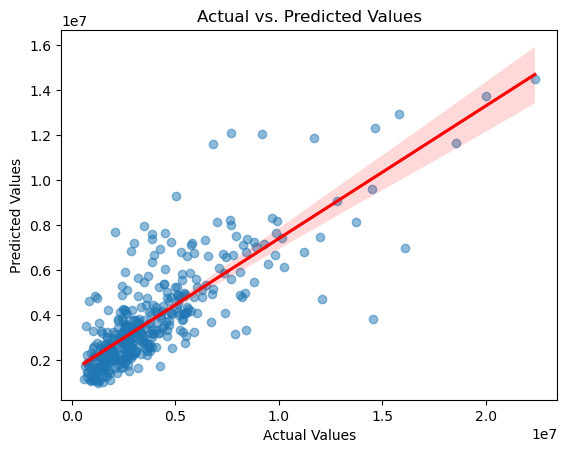

                             feature_importance
uninsured                              0.223658
total_patients                         0.151366
TotalWeeklyHoursOfOperation            0.088806
total_cost_care                        0.062513
total_sfs                              0.060457
total_visits                           0.060151
hispanic_any_race                      0.053597
total_sites                            0.029353
low_income                             0.020226
medicaid                               0.014196
diverse_patients_sum                   0.012682
total_grant_funding                    0.011141
lep_patients                           0.010869
SiteCity_Count                         0.010490
migrant_patients                       0.009704


In [188]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

In [189]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [80, 100, 120],  # Explore around the best found
    'max_depth': [None, 50, 100],    # Explore deeper trees and unrestricted
    'max_features': ['sqrt', 0.5, 'log2'],  # Include a fractional option
    'min_samples_split': [2, 4, 6],  # A bit more granularity around the best found
    'min_samples_leaf': [1, 2, 4],   # Investigate slightly larger leaves
    'criterion': ['friedman_mse', 'squared_error'],  # Include standard MSE for comparison
    'bootstrap': [True],             # Keep as is if no need to change
    'n_jobs': [-1],                  # Use all processors for speed
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_ir, y_train_rounded)

y_pred = forest_gs.predict(X_test_ir)
print(forest_gs.score(X_test_ir, y_test_rounded))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6467941248164882
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120, 'n_jobs': -1}


R2 Score: 0.6496786187559196, Root Mean Squared Error: 1785320.647276867, Mean Absolute Error: 1167132.281638345


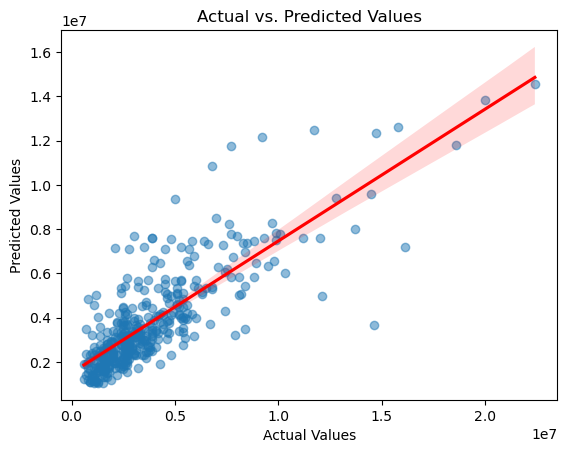

                             feature_importance
uninsured                              0.245745
total_patients                         0.122273
TotalWeeklyHoursOfOperation            0.086912
total_visits                           0.069042
total_sfs                              0.056388
total_cost_care                        0.046324
hispanic_any_race                      0.044910
total_sites                            0.022899
low_income                             0.020738
medicaid                               0.016393
total_grant_funding                    0.012851
diverse_patients_sum                   0.012245
SiteCity_Count                         0.011991
homeless_patients                      0.011739
migrant_patients                       0.010847


In [190]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

In [191]:
X_train_rr_subset = pd.read_csv(DATA_PATH +'modeling/X_train_subset.csv')
X_test_rr_subset = pd.read_csv(DATA_PATH + 'modeling/X_test_subset.csv')
y_train_subset = pd.read_csv(DATA_PATH  +'modeling/y_train_subset.csv').values.ravel()
y_test_subset = pd.read_csv(DATA_PATH + 'modeling/y_test_subset.csv').values.ravel()

R2 Score: 0.5264593575073981, Root Mean Squared Error: 1080127.2368012425, Mean Absolute Error: 834828.9917055106


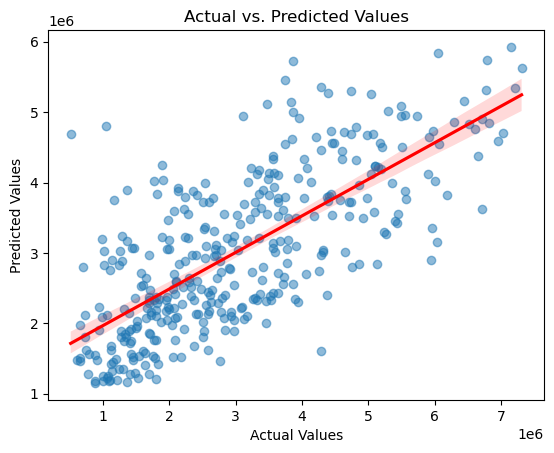

                             feature_importance
total_18_up                            0.210127
total_patients                         0.174972
TotalWeeklyHoursOfOperation            0.051160
uninsured                              0.043110
low_income                             0.036377
total_0_17                             0.027030
migrant_patients                       0.023372
diverse_patients_sum                   0.020553
hispanic_any_race                      0.019422
total_grant_funding                    0.018491
fpl_over_200                           0.017771
homeless_patients                      0.017404
diverse_race_proportion                0.017248
SiteCity_Count                         0.016879
homeless_patients_ratio                0.015713


In [192]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr_subset, y_train_subset)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr_subset, X_test_rr_subset, y_train_subset, y_test_subset)

sns.regplot(x=y_test_subset.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr_subset.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

**Reduced Power Rounded and Reduced Power**